# Trabalho Prático 1: Geometria Computacional

Filipe Pirola Santos - 2021031580

Igor Eduardo Martins Braga - 2022425671

Wallace Eduardo Pereira - 2021032013

# Bibliotecas


In [5]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Limpando e plotando datasets

SVD Completa:

Completa: A SVD completa é uma técnica matemática que fatora uma matriz em três outras matrizes, resultando em todos os valores singulares da matriz original. Em outras palavras, não há perda de informações na SVD completa.
Computacionalmente Intensiva: A SVD completa é computacionalmente intensiva, especialmente para grandes conjuntos de dados, porque envolve todas as singularidades, mesmo aquelas que podem ter valores muito pequenos e próximos a zero.

SVD Truncado (Truncated SVD):

Truncado: O SVD truncado é uma versão aproximada da SVD completa, onde algumas singularidades (valores singulares e vetores singulares) são truncadas, ou seja, são deixadas de fora do cálculo. A redução do número de singularidades resulta em uma aproximação da matriz original com menor dimensionalidade.
Eficiência Computacional: O SVD truncado é computacionalmente mais eficiente, especialmente para grandes conjuntos de dados, porque envolve apenas as singularidades mais significativas, ignorando as que contribuem menos para a variabilidade dos dados.

Diferenças em Contextos Práticos:

Uso em Redução de Dimensionalidade: O SVD truncado é frequentemente usado para redução de dimensionalidade em tarefas como mineração de texto (LSA), recomendação de filmes (filtragem colaborativa), etc. A redução de dimensionalidade é útil para lidar com a maldição da dimensionalidade, economizar espaço de armazenamento e melhorar a eficiência computacional.
Uso em Reconstrução de Matrizes: O SVD completo é útil quando você precisa reconstruir exatamente a matriz original a partir das suas componentes singulares. Isso é importante em certas aplicações científicas e matemáticas.


No contexto de análise de dados e visualização, especialmente para conjuntos de dados como o Iris, onde a redução de dimensionalidade pode ajudar a visualizar os dados em gráficos bidimensionais, o SVD truncado (Truncated SVD) é geralmente preferível. Aqui estão algumas razões pelas quais o Truncated SVD é muitas vezes escolhido para análise de dados e visualização:

Eficiência Computacional: O Truncated SVD é mais eficiente computacionalmente, especialmente quando lidamos com grandes conjuntos de dados. Ele permite reduzir a dimensionalidade sem a necessidade de calcular todas as singularidades da matriz original, o que economiza tempo de computação.

Redução de Dimensionalidade: O Truncated SVD é especificamente projetado para redução de dimensionalidade. Ele captura as direções nos dados que têm a maior variabilidade e, ao truncar os valores e vetores singulares menos importantes, permite representar os dados em um espaço de dimensões reduzidas. Isso é ideal para visualização em gráficos 2D ou 3D.

Preservação de Estruturas Importantes: O Truncated SVD tende a preservar estruturas semânticas dos dados. Em muitos conjuntos de dados, as informações mais importantes podem ser capturadas pelos primeiros componentes principais, e é isso que o Truncated SVD retém.

Facilidade de Interpretação: Ao reduzir os dados para duas ou três dimensões usando o Truncated SVD, os resultados podem ser visualizados em gráficos de dispersão ou gráficos 3D, o que é muito mais fácil de interpretar e entender do que dados em alta dimensionalidade.

Para o conjunto de dados Iris, que é relativamente pequeno e não esparsamente distribuído, você pode usar tanto PCA quanto a Truncated SVD para redução de dimensionalidade para fins de análise gráfica. Ambas as técnicas são apropriadas neste caso, e a escolha entre elas dependerá das suas necessidades específicas e preferências. No entanto, se o seu objetivo principal é a análise gráfica, PCA é geralmente a escolha mais comum e intuitiva.

Razões para Escolher PCA para a Análise Gráfica do Conjunto de Dados Iris:

Interpretabilidade: As componentes principais geradas pelo PCA podem ser interpretadas mais facilmente, pois são combinações lineares dos recursos originais. Isso é útil quando você deseja entender quais características contribuem mais para a variação nos dados.

Visualização Intuitiva: As duas primeiras componentes principais do PCA podem ser facilmente visualizadas em um gráfico bidimensional, permitindo que você visualize os dados em um espaço reduzido e identifique padrões ou agrupamentos.

Amplamente Utilizado: PCA é uma técnica de redução de dimensionalidade amplamente utilizada e compreendida, tornando mais fácil para outros analisarem e interpretarem seus resultados.

Preservação da Variância: PCA preserva a máxima variância possível nos dados originais quando projeta os dados em um espaço de dimensionalidade inferior. Isso significa que as relações entre os pontos de dados são preservadas tanto quanto possível.

Portanto, para análise gráfica do conjunto de dados Iris, recomenda-se usar PCA para reduzir a dimensionalidade para 2 ou 3 componentes principais e, em seguida, visualizar os dados em um gráfico de dispersão (scatter plot) ou em um gráfico tridimensional, se estiver usando três componentes principais. Isso ajudará a ter uma compreensão visual dos padrões nos dados e das relações entre as diferentes classes de flores Iris.

**Função de plotagem dos gráficos**

In [7]:
def plot_scatter(dataframe, legenda):

    sns.scatterplot(data=dataframe, x='X', y='Y', hue='Class', alpha=0.6, palette="deep")

    plt.xlabel('X')
    plt.ylabel('Y')
    if(legenda == 1):
      plt.legend()

    plt.show()

**Função de redução de dimensão do dataset**

In [8]:
def reduce_dimension_dataset(data):
  pca = PCA(n_components=2)
  data = StandardScaler().fit_transform(data)
  componentes = pca.fit_transform(data)
  two_dimensional_df = pd.DataFrame(data=componentes, columns=["X","Y"])

  return two_dimensional_df

## Dataset Iris - Separável

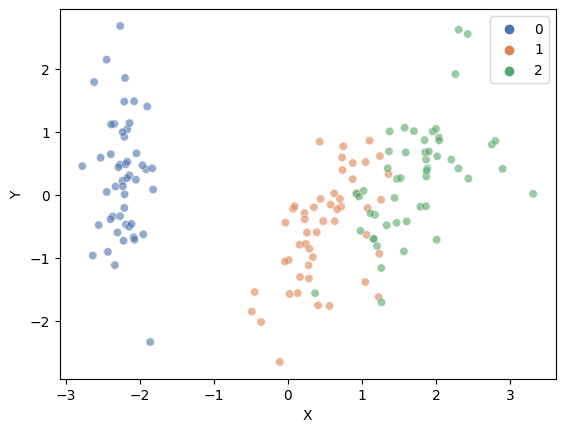

In [9]:
from sklearn.datasets import load_iris

# Carregando dataset Iris
iris = load_iris()

iris_data = iris.data

# Normalizando os dados
normalized_data = StandardScaler().fit_transform(iris_data)

pca = PCA(n_components=2)
components = pca.fit_transform(normalized_data)
iris_df = pd.DataFrame(data=components, columns=["X","Y"])

# Adicionando coluna de Classe no dataset reduzido dimensionalmente
iris_df['Class'] = iris.target

plot_scatter(iris_df, 1)

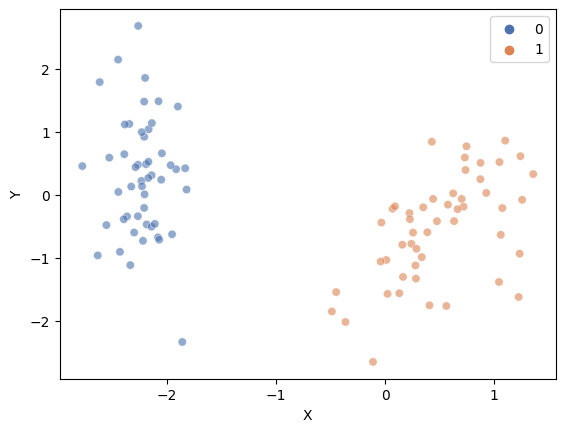

In [10]:
iris_filtered = iris_df[iris_df['Class'] != 2]

plot_scatter(iris_filtered, 1)

## Dataset Wine - Separável

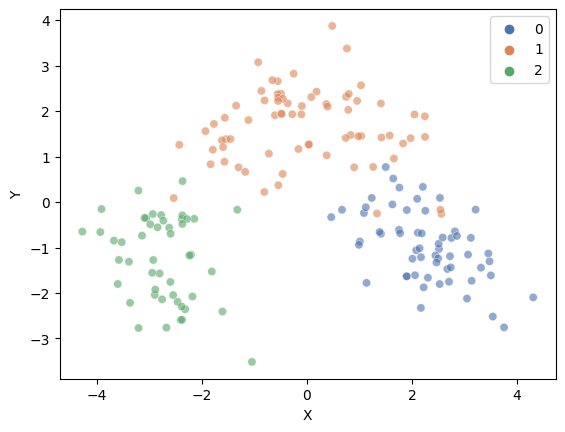

In [11]:
from sklearn.datasets import load_wine

wine = load_wine()
wine_data = wine.data

pca = PCA(n_components=2)
normalized_data = StandardScaler().fit_transform(wine_data)
componentes = pca.fit_transform(normalized_data)
wine_df = pd.DataFrame(data=componentes, columns=["X","Y"])

wine_df['Class'] = wine.target

plot_scatter(wine_df, 1)

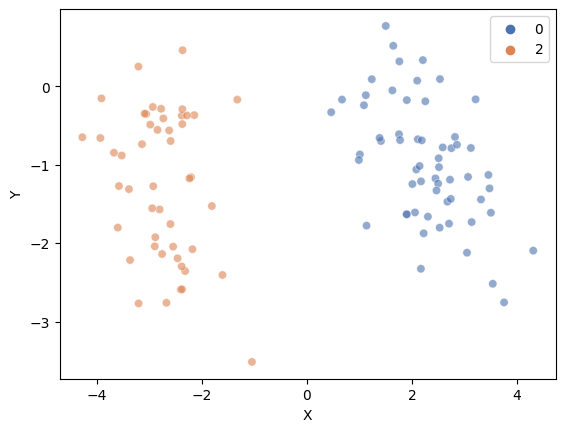

In [12]:
wine_filtered = wine_df[wine_df['Class'] != 1]

plot_scatter(wine_filtered, 1)

## Digits DataSet

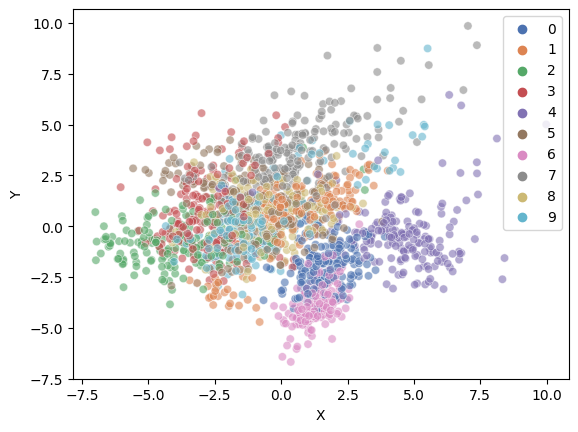

In [13]:
from sklearn.datasets import load_digits

digits = load_digits()
digits_data = digits.data

pca = PCA(n_components=2)
normalized_data = StandardScaler().fit_transform(digits_data)
componentes = pca.fit_transform(normalized_data)
digits_df = pd.DataFrame(data=componentes, columns=["X","Y"])

digits_df['Class'] = digits.target

plot_scatter(digits_df, 1)

## Breast Cancer DataSet

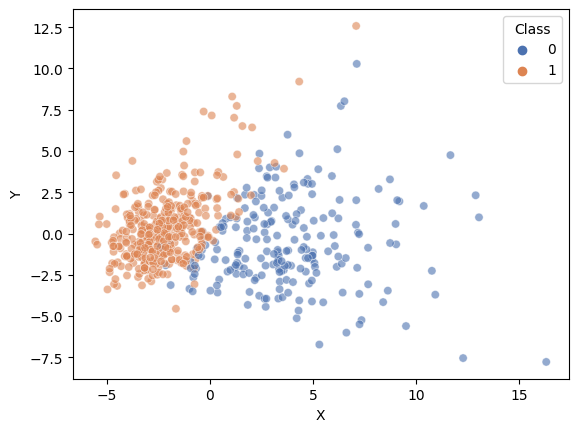

In [342]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()
breast_cancer_data = breast_cancer.data

pca = PCA(n_components=2)
normalized_data = StandardScaler().fit_transform(breast_cancer_data)
componentes = pca.fit_transform(normalized_data)
breast_cancer_df = pd.DataFrame(data=componentes, columns=["X","Y"])

breast_cancer_df['Class'] = breast_cancer.target

plot_scatter(breast_cancer_df, 0)

In [345]:
from sklearn.datasets import load_fetch_olivetti_faces

olivetti_faces = load_fetch_olivetti_faces()
olivetti_faces = olivetti_faces.data

pca = PCA(n_components=2)
normalized_data = StandardScaler().fit_transform(olivetti_faces)
componentes = pca.fit_transform(normalized_data)
olivetti_faces_df = pd.DataFrame(data=componentes, columns=["X","Y"])

olivetti_faces_df['Class'] = olivetti_faces.target

plot_scatter(olivetti_faces_df, 0)

array([[191.,  36.,  50.],
       [189.,  37.,  52.],
       [193.,  38.,  58.],
       [162.,  35.,  62.],
       [189.,  35.,  46.],
       [182.,  36.,  56.],
       [211.,  38.,  56.],
       [167.,  34.,  60.],
       [176.,  31.,  74.],
       [154.,  33.,  56.],
       [169.,  34.,  50.],
       [166.,  33.,  52.],
       [154.,  34.,  64.],
       [247.,  46.,  50.],
       [193.,  36.,  46.],
       [202.,  37.,  62.],
       [176.,  37.,  54.],
       [157.,  32.,  52.],
       [156.,  33.,  54.],
       [138.,  33.,  68.]])